# Visualizing traffic congestion data

In [4]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# geographical plotting
import geopandas as gpd

# imports for widgets and interactive tools
import plotly.graph_objs as go
from ipywidgets import widgets
from IPython.display import display

# dashboard
import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html

#### Load the data

In [5]:
# import the data
train_df = pd.read_csv('trafficData.csv')
test_df = pd.read_csv('test.csv')

#### Split the data by city

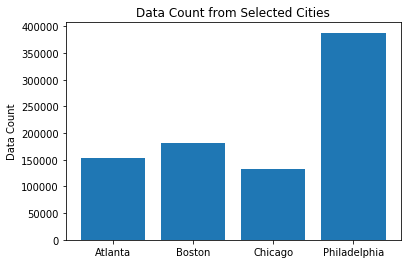

In [5]:
# split df by city
atlanta = train_df[train_df['City'] == 'Atlanta']
boston = train_df[train_df['City'] == 'Boston']
chicago = train_df[train_df['City'] == 'Chicago']
philadelphia = train_df[train_df['City'] == 'Philadelphia']

# write a function that shows how much data comes from each city
def data_count(df_list):
    # create lists for the count and city
    data_count = []
    cities = []
    # loop through the list
    for df in df_list:
        data_count.append(df.shape[0])
        cities.append(df['City'].iloc[0])

    data_count = np.array(data_count)
    
    # plot the data
    plt.bar(cities, data_count)
    plt.title('Data Count from Selected Cities')
    plt.ylabel('Data Count')
    plt.show()

data_count([atlanta, boston, chicago, philadelphia])
            

Another view at the data, by creating a dropdown menu to select data for a certain city.

In [6]:
# widget to control df output by city
def unique_values_ALL(df, column):
    unique = df[column].unique().tolist()
    unique.sort()
    unique.insert(0, 'ALL')
    return unique
#unique_values_ALL(train_df, 'City')
dropdown_city = widgets.Dropdown(options=unique_values_ALL(train_df, 'City'))

output_city = widgets.Output()
# when all is selected display all data, otherwise apply filter
def dropdown_city_handler1(change):
    # clear output
    output_city.clear_output()
    # check with filter
    with output_city:
        if(change.new == 'ALL'):
            display(train_df)
        else:
            display(train_df[train_df['City'] == change.new])

# bind the handler to the dropdown
dropdown_city.observe(dropdown_city_handler1, names='value')

# display
display(dropdown_city)
        

Dropdown(options=('ALL', 'Atlanta', 'Boston', 'Chicago', 'Philadelphia'), value='ALL')

In [7]:
# call display here to put the changing output in this cell
display(output_city)

Output()

#### First look at the data
Things we would like to know about our data at first glance:
* data type
* missing values
* unique values
* summary statistics such as mean, std, min, max

The following function creates a complete summary table for a selected city or the whole dataset.

In [8]:
# for a selected city or multiple city describe the data
# df_list specifies which cities should be included in the summary
def data_summary(df_list):
    # check how many cities and create a df of all selected cities
    if len(df_list) > 1:
        complete_df = pd.concat(df_list, axis=0)
    else:
        complete_df = df_list[0]
        
    # use pythons describe method
    describe_table = complete_df.describe().transpose().reset_index()

    # add values such as missing values and unique values
    add_summary = pd.DataFrame(complete_df.dtypes)
    add_summary = add_summary.reset_index()
    add_summary.columns = ['index', 'dtype']
    add_summary['Missing'] = complete_df.isnull().sum().values
    add_summary['Unique'] = complete_df.nunique().values

    # combine both tables

    complete_summary = pd.merge(add_summary,describe_table, 
                               on='index', how='outer')
    complete_summary.rename(columns={'index':'Variable Name'}, inplace=True)
    return complete_summary

data_summary([atlanta])

,Variable Name,dtype,Missing,Unique,count,mean,std,min,25%,50%,75%,max
0,RowId,int64,0,153363,153363.0,1.997016e+06,44272.229004,1.920335e+06,1.958676e+06,1.997016e+06,2.035356e+06,2073697.000
1,IntersectionId,int64,0,377,153363.0,2.642227e+02,144.891429,0.000000e+00,1.450000e+02,2.700000e+02,3.800000e+02,520.000
2,Latitude,float64,0,352,153363.0,3.376832e+01,0.033059,3.364997e+01,3.375175e+01,3.377128e+01,3.378840e+01,33.835
3,Longitude,float64,0,361,153363.0,-8.439191e+01,0.040105,-8.453519e+01,-8.440729e+01,-8.438900e+01,-8.436868e+01,-84.291
4,EntryStreetName,object,3132,295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ExitStreetName,object,2476,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,EntryHeading,object,0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ExitHeading,object,0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Hour,int64,0,24,153363.0,1.267857e+01,6.586600,0.000000e+00,8.000000e+00,1.300000e+01,1.800000e+01,23.000
9,Weekend,int64,0,2,153363.0,3.621278e-01,0.480617,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000


#### Exploring the data 
* see data counts, distributions of stop times for cities

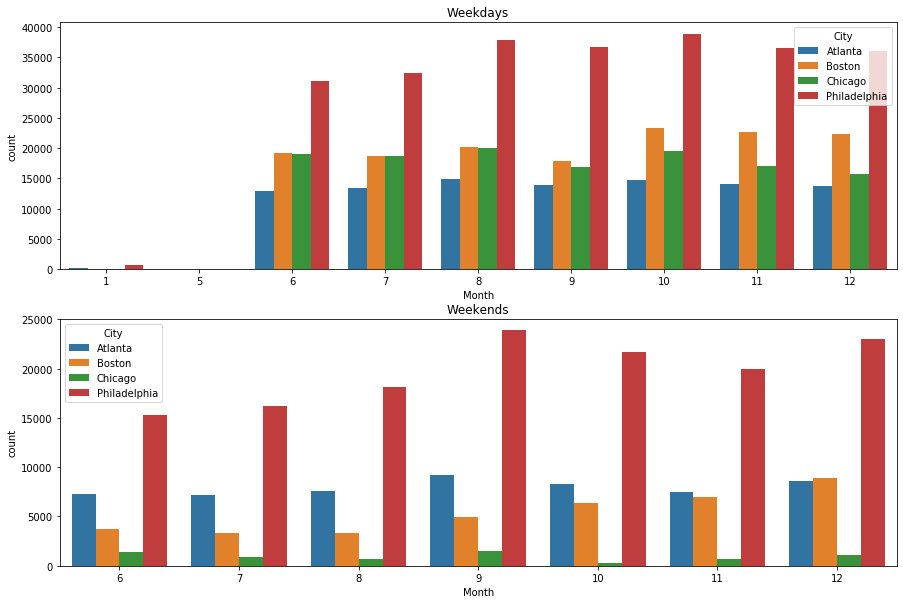

In [9]:
# function for all or selected cities when combining dfs to show the counts
def count_plot_time(df_list, time):
    # check how many cities
    if len(df_list) > 1:
        complete_df = pd.concat(df_list, axis=0)
    else:
        complete_df = df_list[0]
    
    # create the plot
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    sns.countplot(data=complete_df[complete_df['Weekend'] == 0],
                  hue='City', x=time, ax = axs[0])
    sns.countplot(data=complete_df[complete_df['Weekend'] == 1],
                  hue='City', x=time, ax = axs[1])
    # add labels
    axs[0].set_title('Weekdays')
    axs[1].set_title('Weekends')

count_plot_time([atlanta, boston, chicago, philadelphia], 'Month')

Distribution of Stoppage times per hour of the day

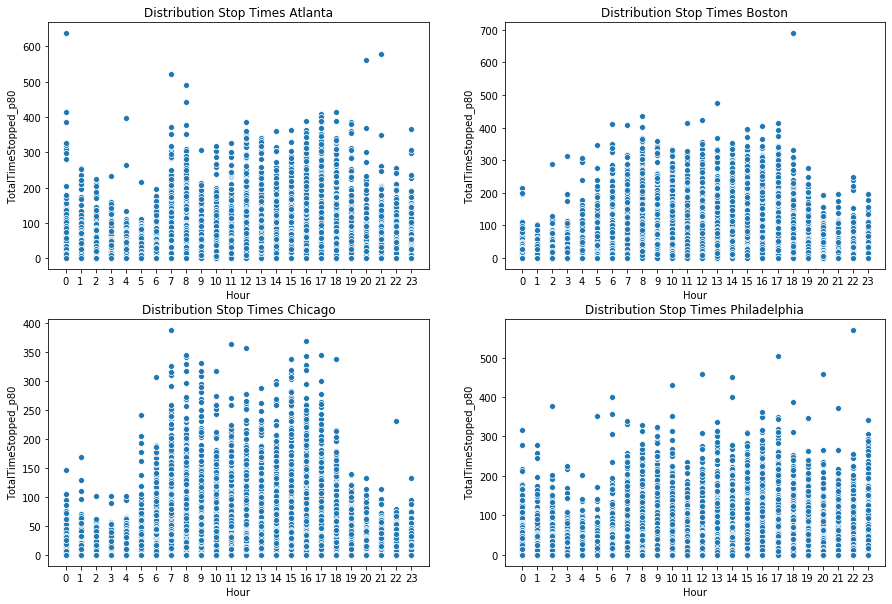

In [10]:
# distribution of stoppage times per hour of day
# function can take a list of cities for which data will be plotted and 
# appropriate figures will be created
def scatter_waiting_time(df_list):
    
    # create ticks for the hours
    x_ticks = np.arange(24)
    
    # create subplots based on how many cities selected
    if len(df_list) == 1:
        fig = plt.figure(1, figsize=(9, 6))
        ax = fig.add_subplot(111)
        sns.scatterplot(df_list[0]['Hour'], df_list[0]['TotalTimeStopped_p80'], ax=ax)
        ax.set_title('Distribution Stop Times ' + df_list[0]['City'].iloc[0])
        ax.set_xticks(x_ticks)
        return 0
    if len(df_list) == 2:
        fig, axs = plt.subplots(1, 2, figsize=(15, 10), sharey=True)
        sns.scatterplot(df_list[0]['Hour'], df_list[0]['TotalTimeStopped_p80'], ax=axs[0])
        axs[0].set_title('Distribution Stop Times ' + df_list[0]['City'].iloc[0])
        axs[0].set_xticks(x_ticks)
        sns.scatterplot(df_list[1]['Hour'], df_list[1]['TotalTimeStopped_p80'], ax=axs[1])
        axs[1].set_title('Distribution Stop Times ' + df_list[1]['City'].iloc[0])
        axs[1].set_xticks(x_ticks)
        return 0
    if len(df_list) == 3:
        fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
        fig.delaxes(axs[1][1])
        sub_rows = 0
    if len(df_list) == 4:
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        sub_rows = 0
    
    # i parameter to keep track of what row to plot in
    i = sub_rows
    for idx, df in enumerate(df_list):
        data_idx = idx
        
        # reset the index to plot in first or second column
        if idx == 2:
            idx=0
        if idx == 3:
            idx=1
            
        # make the plot
        sns.scatterplot(df_list[data_idx]['Hour'], df_list[data_idx]['TotalTimeStopped_p80'], ax=axs[i][idx])
        axs[i][idx].set_title('Distribution Stop Times ' + df_list[data_idx]['City'].iloc[0])
        axs[i][idx].yaxis.set_tick_params(labelbottom=True)
        axs[i][idx].set_xticks(x_ticks)
        
        # switch to next row
        if idx == 1:
            i = 1
        
scatter_waiting_time([atlanta, boston, chicago, philadelphia])   

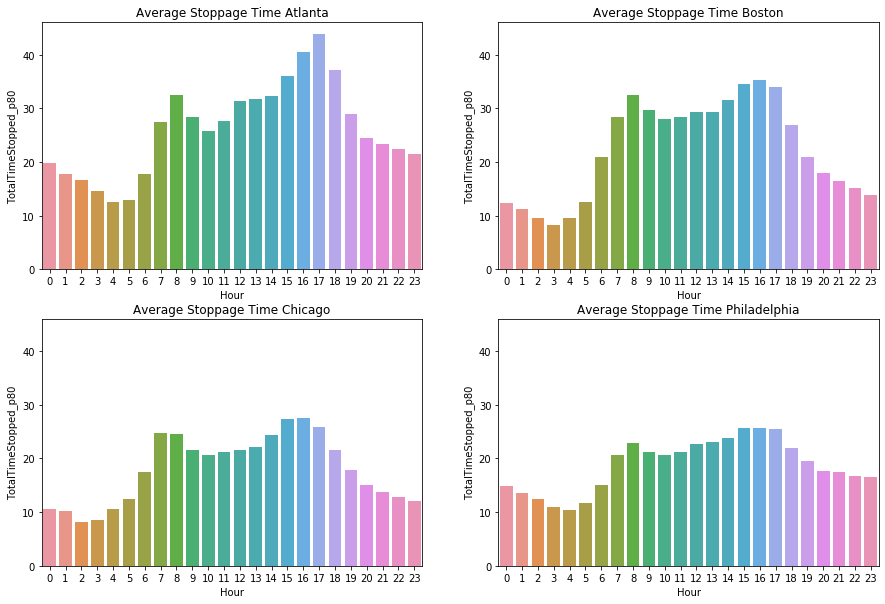

In [11]:
# average stoppage times
# distribution of stoppage times per hour of day 
# the funciton takes a list of cities and will plot their data in the appropriate figure size
def average_waiting_time(df_list):
    
    # create ticks for the hours
    # x_ticks = np.arange(24)
    
    # create subplots based on how many cities selected
    if len(df_list) == 1:
        fig = plt.figure(1, figsize=(9, 6))
        ax = fig.add_subplot(111)
        city_hours = df_list[0].groupby('Hour')['TotalTimeStopped_p80'].mean().reset_index()
        print(city_hours)
        sns.barplot(city_hours['Hour'], city_hours['TotalTimeStopped_p80'], ax=ax)
        ax.set_title('Average Stoppage Time ' + df_list[0]['City'].iloc[0])
        #ax.set_xticks(x_ticks)
        return 0
    if len(df_list) == 2:
        # set up graph
        fig, axs = plt.subplots(1, 2, figsize=(15, 10), sharey=True)
        
        # plot first graph
        city_hours_1 = df_list[0].groupby('Hour')['TotalTimeStopped_p80'].mean().reset_index()
        sns.barplot(city_hours_1['Hour'], city_hours_1['TotalTimeStopped_p80'], ax=axs[0])
        axs[0].set_title('Average Stoppage Time ' + df_list[0]['City'].iloc[0])
        #axs[0].set_xticks(x_ticks)
        
        # plot second graph
        city_hours_2 = df_list[1].groupby('Hour')['TotalTimeStopped_p80'].mean().reset_index()
        sns.barplot(city_hours_2['Hour'], city_hours_2['TotalTimeStopped_p80'], ax=axs[1])
        axs[1].set_title('Average Stoppage Time ' + df_list[1]['City'].iloc[0])
        #axs[1].set_xticks(x_ticks)
        
        return 0
    if len(df_list) == 3:
        fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
        #fig.subplots_adjust(wspace=0.2, hspace=0.4)
        # delete bottom right plot
        fig.delaxes(axs[1][1])
        sub_rows = 0
    if len(df_list) == 4:
        fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
        #fig.subplots_adjust(wspace=0.2, hspace=0.2)
        sub_rows = 0
    
    # i parameter to keep track of what row to plot in
    i = sub_rows
    for idx, df in enumerate(df_list):
        # separate data index to go through list
        data_idx = idx

        # reset the index to plot in first or second column
        if idx == 2:
            idx=0
        if idx == 3:
            idx=1
            
        # get the needed data
        city_hours = df_list[data_idx].groupby('Hour')['TotalTimeStopped_p80'].mean().reset_index()
        # make the plot
        sns.barplot(city_hours['Hour'], city_hours['TotalTimeStopped_p80'], ax=axs[i][idx])
        axs[i][idx].set_title('Average Stoppage Time ' + df_list[data_idx]['City'].iloc[0])
        axs[i][idx].yaxis.set_tick_params(labelbottom=True)
        #axs[i][idx].set_xticks(x_ticks)
        
        # switch to next row
        if idx == 1:
            i = 1
            
average_waiting_time([atlanta, boston, chicago, philadelphia])

#### Geographical representation of the data
* plot the data by latitude and longitude
* show colors based on stoppage times in seconds: blue (0-10), green(10-20), orange(20-40), red(>40)
* one way to do this is with geopandas and a shape file, another with the folium library

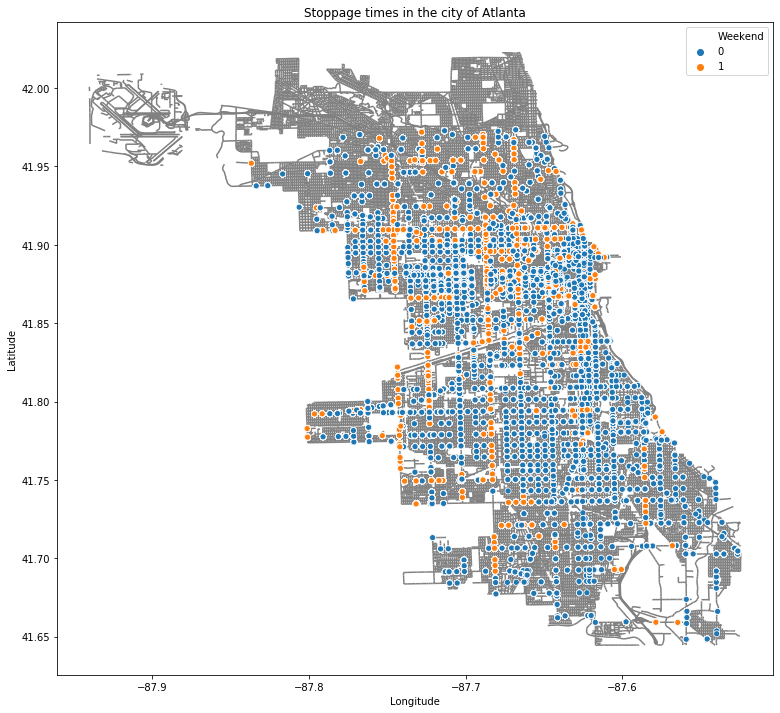

In [12]:
# plotting with geopandas
chi_street_map = gpd.read_file('geo_export_8cd64e00-4caa-4f61-8e59-17ef9a11638a.shp')

# function takes the city dataframe and a map in the form of a shape file
def geo_pandas(df, street_map):
    # create the plot and the basemap
    fig, ax = plt.subplots(figsize=(15, 12))
    street_map.plot(ax=ax, color='grey', zorder=0)
    
    # select longitude and latitude
    longitude = df['Longitude']
    latitude = df['Latitude']
    
    # plot the data with hue=weekend, so the plot shows the incidents on weekends and weekday
    sns.scatterplot(x=longitude, y=latitude, hue='Weekend', data=df, ax=ax)
    #ax.clim(0, 100)
    #fig.colorbar(s1, ax=ax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    #ax.set(xlim=(df['Longitude'].min(), df['Longitude'].max()), ylim=(df['Latitude'].min(), df['Latitude'].max()))
    ax.set_title('Stoppage times in the city of Atlanta')
    
    
geo_pandas(chicago, chi_street_map)

In this plot we can see that there is a lot more data taken on weekdays than on weekends and that certain regions are less covered during weekends.

In [13]:
import folium
    
# city map function can take a city as an argument and will show the appropriate city map
def city_map(df):
    # as there are more than 100,000 data points per city, create a random sample to plot
    df = df.sample(500)

    # make a new column based on the 80th percentile stoppage times
    col = 'TotalTimeStopped_p80'
    conditions = [df[col] <= 10,
                 (df[col] > 10) & (df[col] <= 20),
                 (df[col] > 20) & df[col] <= 40,
                 df[col] > 40]
    choices = [0, 1, 2, 3]
    df['StopColors'] = np.select(conditions, choices, default=np.nan)
    
    # create dictionary for colors
    colors = {0: 'blue', 1: 'green', 2: 'orange', 3: 'red'}
    
    # find mean latitude and longitude for intital map zoom
    mean_lat = df['Latitude'].mean()
    mean_long = df['Longitude'].mean()
    
    # create the folium map
    city_map = folium.Map(location=[mean_lat, mean_long], zoom_start=11)
    
    # plot the data on the map with appropriate colors
    for lat, long, size, color_range in zip(df['Latitude'], df['Longitude'], df['TotalTimeStopped_p80'], df['StopColors']):
        folium.CircleMarker([lat, long], radius=1, color=colors[color_range],
                            threshold_scale=[0,1,2,3], fill=True).add_to(city_map)
    
    return city_map
    
city_map(chicago)
    


In [14]:
#get uniqe cities
train_df['City'].unique()

array(['Atlanta', 'Boston', 'Chicago', 'Philadelphia'], dtype=object)